# Natural Language Processing Tutorial 1 - Static Word Embeddings with Word2Vec
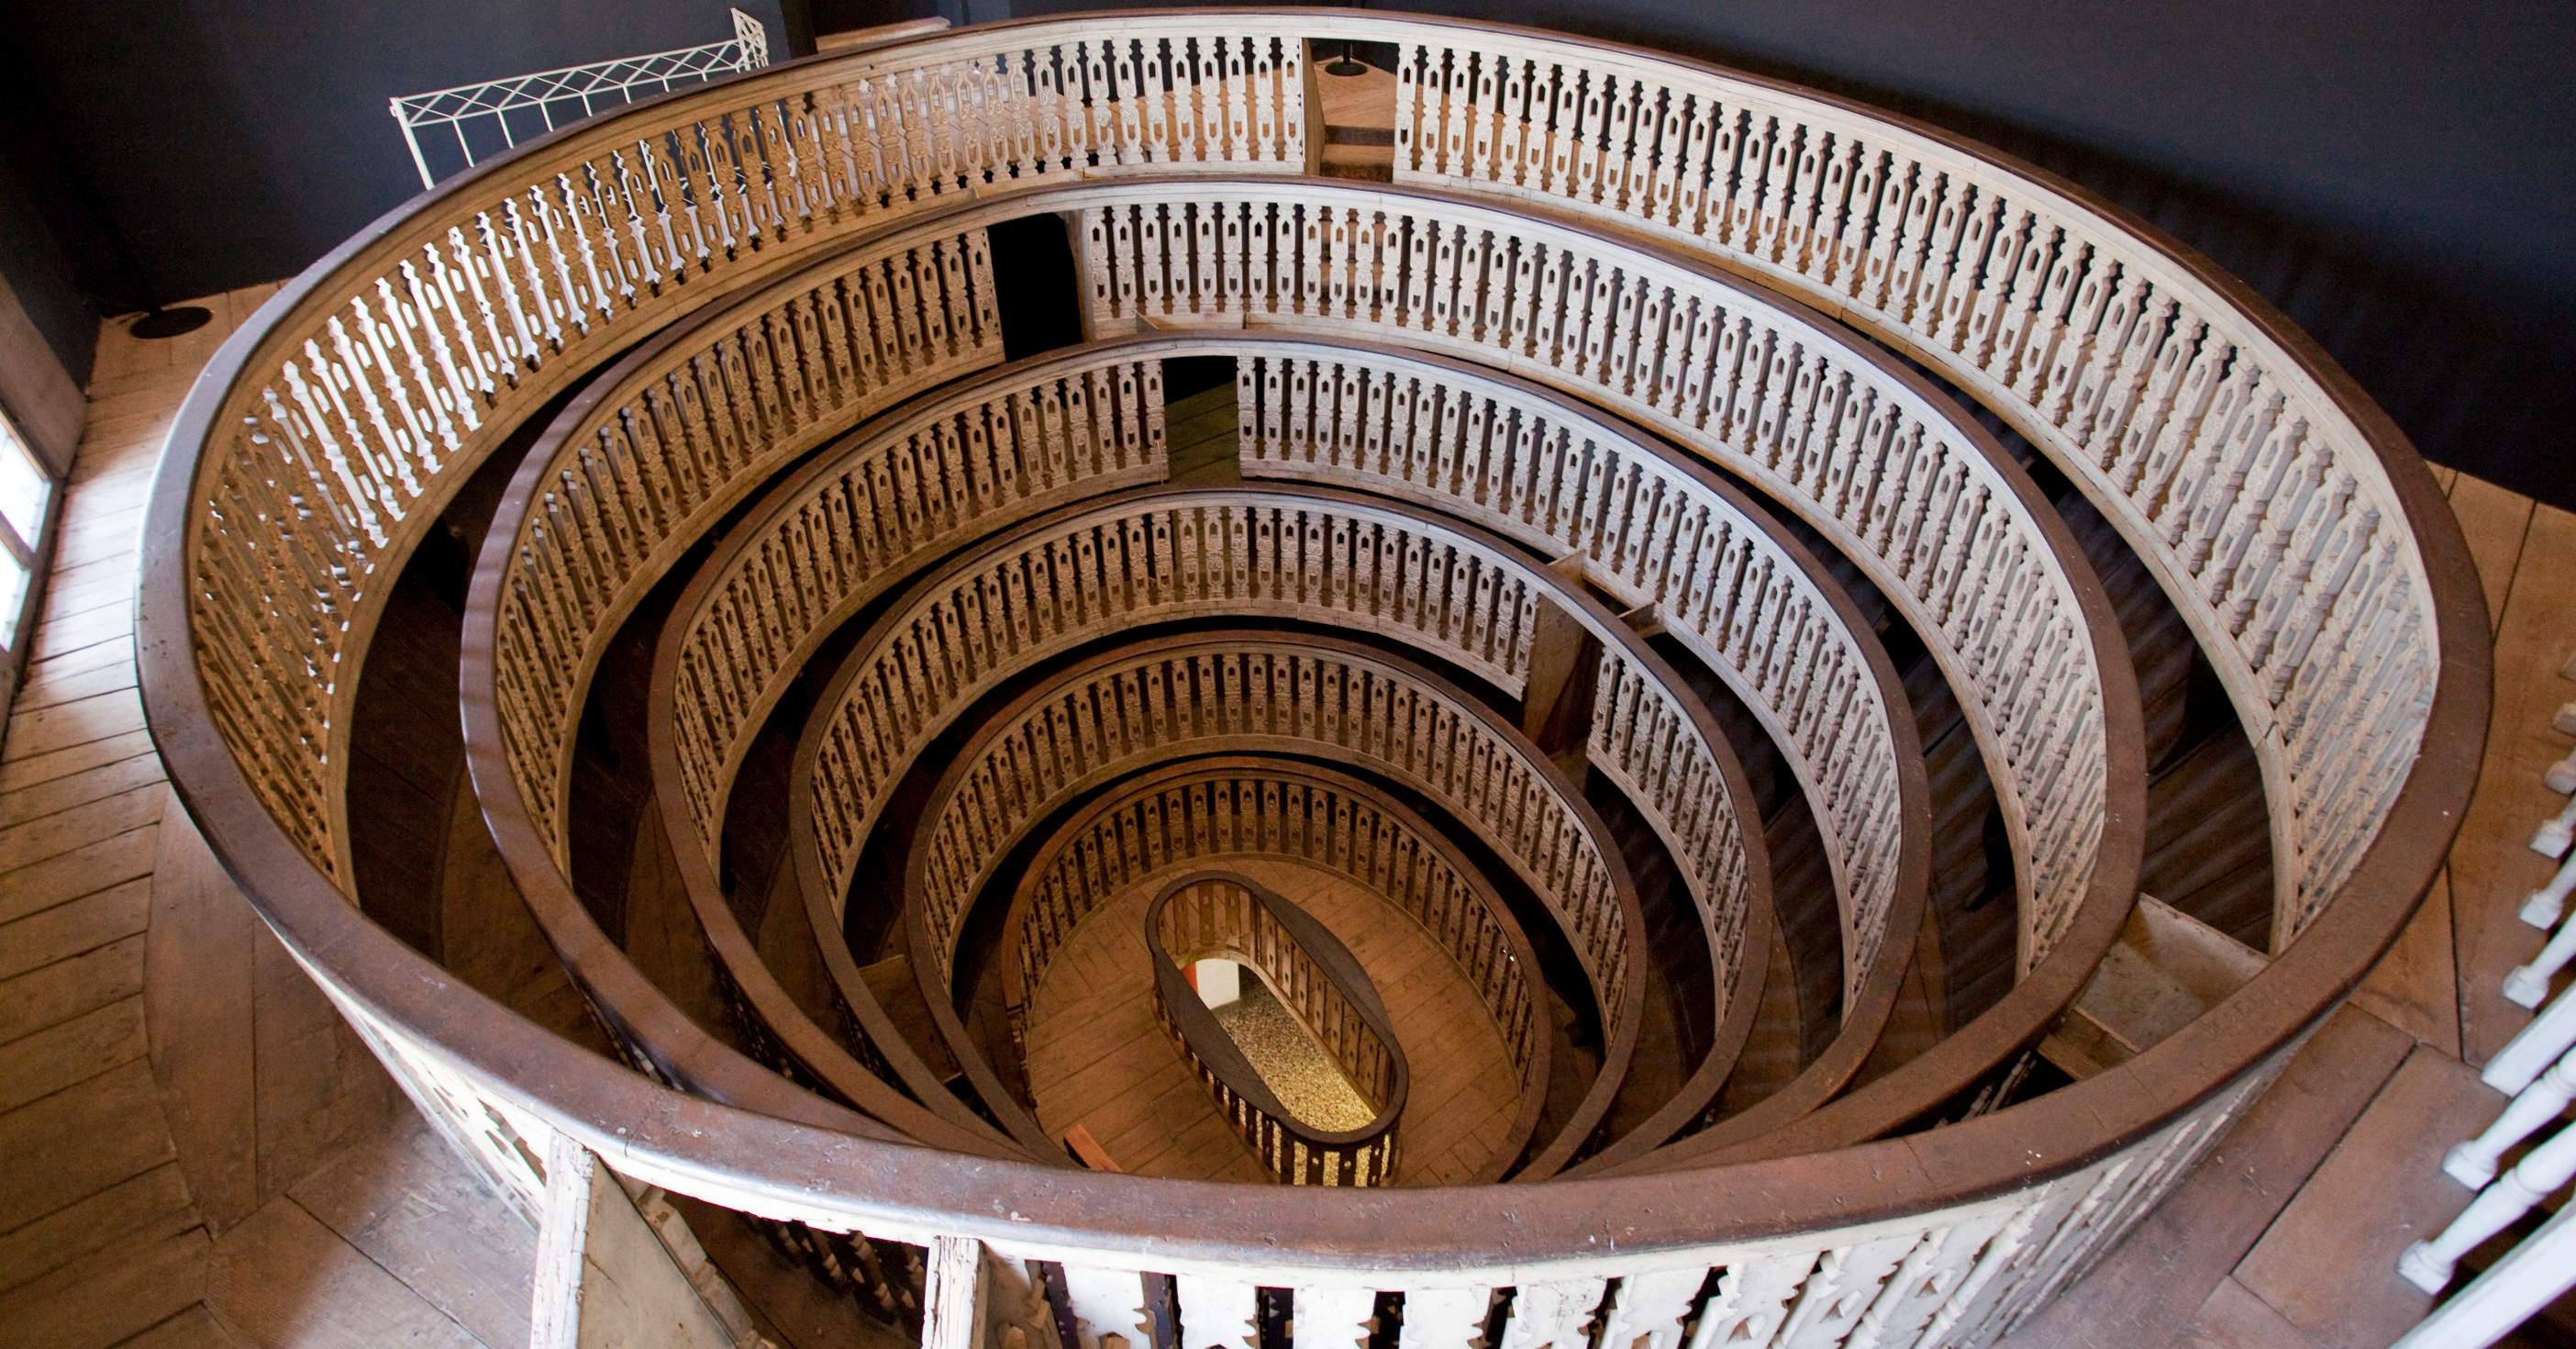

## What you'll learn in this tutorial

- We'll use the [gensim](https://radimrehurek.com/gensim/index.html) library to:
    - explore pretrained word embeddings
    - pretrain our own embeddings
- We will additionally:
    - visualize word embeddings
    - evaluate them intrisically and extrinsically

## Our schedule for today

- Part 1: Using pretrained word embeddings with gensim
    - How to download already pretrained embeddings
    - Nearest neighbour similarity search 
    - Word embedding visualization via PCA
    - Intrisic evaluation with word analogy and word similarity benchmarks
    - **Task 1**
- Part 2: Pretraining your **own** embeddings
    - Training choices
    - Saving and loading your embeddings
- Part 3: Extrinsic evaluation of word embeddings
    - Using word2vec embeddings for spam classification
    - **Task 2**

## Part 1 : Using pretrained embeddings with gensim

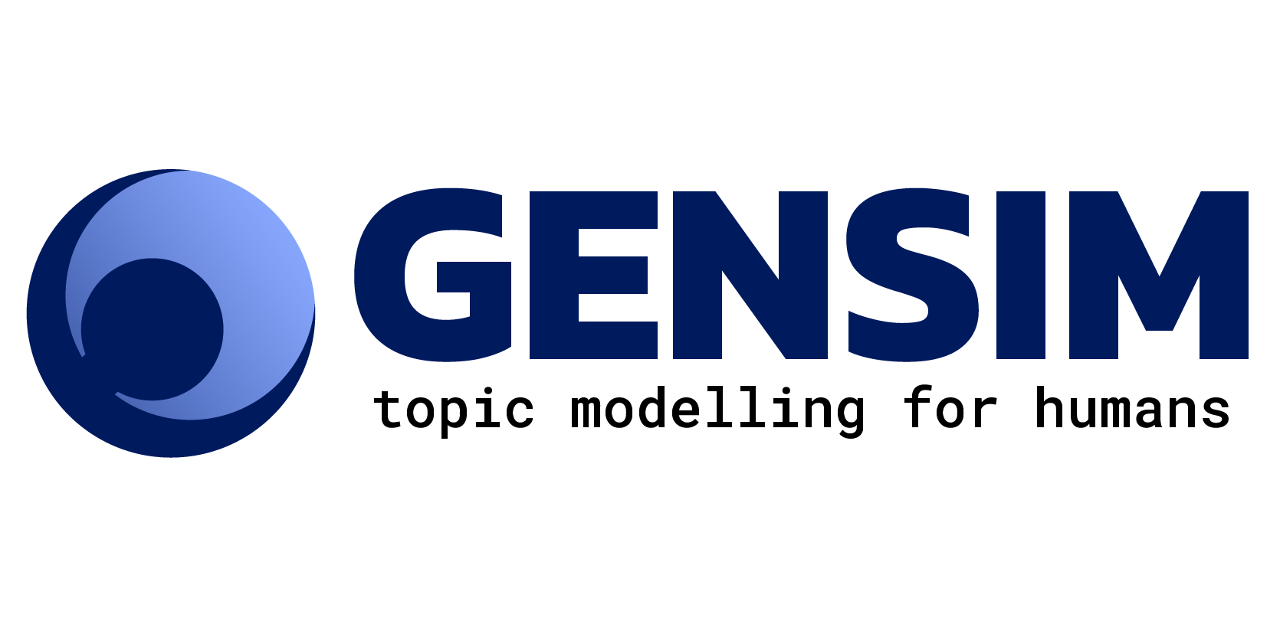

### What is gensim?

- Gensim is one of many core NLP libraries:
    - together with [NLTK](https://www.nltk.org), [spaCy](https://spacy.io) and [HuggingFace 🤗](https://huggingface.co)
    - you can find its documentation [here](https://radimrehurek.com/gensim/auto_examples/index.html#other-resources)
- It can be used to deal with corpora and perform:
    - Retrieval
    - Topic Modelling
    - Representation Learning (**word2vec** and **doc2vec**)

In [1]:
# Run this cell now!
import gensim

import numpy as np
import pandas as pd

import gensim.downloader as api
from gensim import utils
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
from gensim.models import Word2Vec

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder

from scipy.stats import pearsonr, spearmanr

import nltk
from nltk.corpus import stopwords

import torch
import torch.nn as nn

import plotly.express as px

### Let's download some embeddings!

In [2]:
# Run this cell now!
word_emb = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
api.info()

- The object that we get is of type [KeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html)
- This is simply a map  $w \rightarrow \mathbf{e}_w \in \mathbb{R}^{300}$
- You can explore [here](https://github.com/RaRe-Technologies/gensim-data#models) all the possible models or simply run ```api.info()```

### How do these embeddings look like?

In [ ]:
# Access embeddings with word-lookup
print(word_emb["apple"].shape)
print(word_emb["apple"])

(300,)
[-0.06445312 -0.16015625 -0.01208496  0.13476562 -0.22949219  0.16210938
  0.3046875  -0.1796875  -0.12109375  0.25390625 -0.01428223 -0.06396484
 -0.08056641 -0.05688477 -0.19628906  0.2890625  -0.05151367  0.14257812
 -0.10498047 -0.04736328 -0.34765625  0.35742188  0.265625    0.00188446
 -0.01586914  0.00195312 -0.35546875  0.22167969  0.05761719  0.15917969
  0.08691406 -0.0267334  -0.04785156  0.23925781 -0.05981445  0.0378418
  0.17382812 -0.41796875  0.2890625   0.32617188  0.02429199 -0.01647949
 -0.06494141 -0.08886719  0.07666016 -0.15136719  0.05249023 -0.04199219
 -0.05419922  0.00108337 -0.20117188  0.12304688  0.09228516  0.10449219
 -0.00408936 -0.04199219  0.01409912 -0.02111816 -0.13476562 -0.24316406
  0.16015625 -0.06689453 -0.08984375 -0.07177734 -0.00595093 -0.00482178
 -0.00089264 -0.30664062 -0.0625      0.07958984 -0.00909424 -0.04492188
  0.09960938 -0.33398438 -0.3984375   0.05541992 -0.06689453 -0.04467773
  0.11767578 -0.13964844 -0.26367188  0.17480

In [5]:
# Access embeddings with index-lookup
print(word_emb[10])

KeyedVectors<vector_size=300, 3000000 keys>


### Let's check the vocabulary

- Two important attributes:
    - ```key_to_index``` : maps a word to its vocabulary index
    - ```index_to_key``` : maps a vocabulary index to corresponding word

In [14]:
print(f"Vocabulary length {len(word_emb.key_to_index)}")
print(f"Index of cat {word_emb.key_to_index['cat']}") # from word to index
print(f"Word at position 5947 {word_emb.index_to_key[5947]}") # from index to word

Vocabulary length 3000000
Index of cat 5947
Word at position 5947 cat


### Compute similarity and distance

In [15]:
pairs = [
    ('car', 'minivan'),   
    ('car', 'bicycle'),   
    ('car', 'airplane'),  
    ('car', 'cereal'),    
    ('car', 'communism'),
]
print("w1     w2    cos_sim   cos_dist")
for w1, w2 in pairs:
    print(f"{w1}  {w2}  {word_emb.similarity(w1, w2):.3f}  {word_emb.distance(w1, w2):.3f}")
    

w1     w2    cos_sim   cos_dist
car  minivan  0.691  0.309
car  bicycle  0.536  0.464
car  airplane  0.424  0.576
car  cereal  0.139  0.861
car  communism  0.058  0.942


### Nearest Neighbour (NN) Retrieval // Similarity Search

- gensim has a ```most_similar``` function:
    - however, it does not perform exhaustive nearest-neighbour research
    - given a query word $w_q$ we want to find a ranked list $L_q$ of words in vocabulary $V$
    in decreasing order of cosine similarity
    - e.g. $w_q$ = "joy" then $L_q$ = ["joy", "happiness",... ]
- We can write our own function!

In [29]:
def retrieve_most_similar(query_words, all_word_emb, restrict_vocab=10000):
    
    # Step 1: Get full or restricted vocabulary embeddings
    # If restrict_vocab=None then we have exhaustive search, otherwise we restrict the vocab to the most frequent words
    vocab_emb = all_word_emb.vectors[:restrict_vocab+1,:] if restrict_vocab is not None else all_word_emb.vectors # shape: |V_r| x word_emb_size
    
    # Step 2: get the word embeddings for the query words
    query_emb = all_word_emb[query_words] # shape: |Q| x word_emb_size
    
    # Step 3: get cosine similarity between queries and embeddings
    cos_sim = cosine_similarity(query_emb, vocab_emb) # shape: |Q| x |V_r|
    
    # Step 4: sort similarities in desceding orders and get indices of nearest neighbours
    nn = np.argsort(-cos_sim) # shape: |Q| x |V_r|
  
    # Step 5: delete self-similarity, i.e. cos_sim(w,w)=1.0 
    nn_filtered = nn[:, 1:] # remove self_similarity
    
    # Step 6: use the indices to get the words
    nn_words = np.array(word_emb.index_to_key)[nn_filtered]
    
    return nn_words

In [30]:
queries = ["king", "queen", "italy", "Italy", "nurse"]
res = retrieve_most_similar(queries, word_emb, restrict_vocab=100000)
top_k = 10
res_k = res[:, :top_k]
del res
print(res_k)

[['kings' 'queen' 'monarch' 'crown_prince' 'prince' 'sultan' 'ruler'
  'princes' 'throne' 'royal']
 ['queens' 'princess' 'king' 'monarch' 'Queen' 'princesses' 'royal'
  'prince' 'duchess' 'Queen_Elizabeth_II']
 ['french' 'Italy' 'i' 'haha' 'Cagliari' 'india' 'dont' 'thats' 'mr'
  'lol']
 ['Italian' 'Sicily' 'Italians' 'ITALY' 'Spain' 'Bologna' 'Italia'
  'France' 'Milan' 'Romania']
 ['registered_nurse' 'nurses' 'nurse_practitioner' 'midwife' 'Nurse'
  'nursing' 'doctor' 'medic' 'pharmacist' 'paramedic']]


### Dimensionality Reduction and Plotting

- We want to plot our word embeddings
- But they ''live'' in $\mathbb{R}^{300}$
- Let's use dimensionality reduction techniques, like PCA

In [32]:
all_res_words = res_k.flatten()
res_word_emb = word_emb[all_res_words]
print("(|Q| x k) x word_emb_size")
print(res_word_emb.shape)

(|Q| x k) x word_emb_size
(50, 300)


In [33]:
pca = PCA(n_components=3) #Perform 3d-PCA
word_emb_pca = pca.fit_transform(res_word_emb)

In [35]:
pca_df = pd.DataFrame(word_emb_pca, columns=["pca_x", "pca_y", "pca_z"])

pca_df["word"] = res_k.flatten()

labels = np.array([queries]).repeat(top_k)
pca_df["query"] = labels

print(pca_df.head())

      pca_x     pca_y     pca_z          word query
0 -0.951781 -0.588460  0.546893         kings  king
1 -1.366600 -0.059902  0.103551         queen  king
2 -2.038809 -0.398816 -0.404129       monarch  king
3 -1.730923 -0.289501 -0.157777  crown_prince  king
4 -1.596841 -0.419768 -0.252164        prince  king


In [36]:
px.scatter_3d(pca_df, x='pca_x', y='pca_y', z='pca_z', color="query", text="word", opacity=0.7, title="3d-PCA representation of word embeddings")

### Word embedding evaluation

- There are two main types of evaluation:
    - intrisic evaluation: evaluate word embeddings without a downstream task
        - word similarity benchmarks
        - word analogy benchmarks
    - extrinsic evaluation: evaluate word embeddings on a downstream task

#### Word Similarity Benchmarks
- Word similarity benchmarks, such as WS353, contain word pairs and a human-given similarity score


In [37]:
ws353_df = pd.read_csv(datapath('wordsim353.tsv'), sep="\t", skiprows=1).rename(columns={"# Word 1": "Word 1"})
ws353_df.sample(5)

,Word 1,Word 2,Human (mean)
304,environment,ecology,8.81
58,vodka,gin,8.46
345,preservation,world,6.19
72,magician,wizard,9.02
186,delay,news,3.31


- To evaluate word embeddings, we need to do three steps:
1. For each pair $(w_{i_{1}}, w_{i_{2}})$ we get the embeddings $(\mathbf{e}_{w_{i_{1}}}, \mathbf{e}_{w_{i_{2}}})$
2. For each pair we compute the cosine similarity between its word embeddings $s_i = \cos(\mathbf{e}_{w_{i_{1}}}, \mathbf{e}_{w_{i_{2}}})$
3. We compute a correlation score ([Pearson's $r$](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) or [Spearman's $\rho$](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)) between the human given scores $h_i$ and the cosine similarities $s_i$
    - the higher the score, the better!

##### Evaluating word similarity with gensim

- gensim allows us to do everything with the [```evaluate_word_pairs```](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.evaluate_word_pairs) function

In [38]:
word_emb.evaluate_word_pairs(datapath('wordsim353.tsv'), case_insensitive=False)

(PearsonRResult(statistic=0.652534960755016, pvalue=3.373419984050465e-44),
 SignificanceResult(statistic=0.7000166486272194, pvalue=2.86866666051422e-53),
 0.0)

#### Word analogy benchmarks

- When doing word analogy resolution with word embeddings, we want to solve equations such as

    *man : king = woman : x*

- word2vec paper shows that word2vec embeddings can solve (some) of these equations by algebric operations:
1. Get $\mathbf{e}_x = \mathbf{e}_{king} - \mathbf{e}_{man} + \mathbf{e}_{woman}$
2. Check if $NN_{V}(\mathbf{e}_x) = \text{queen}$
    

##### Evaluating word analogies with gensim
- gensim provides us with a [```most_similar```]() function
- It has several arguments, the most important are:
    - ```positive``` : list of words that should be summed together
    - ```negative``` : list of words that should be subtracted
- In formulas, this function computes:
$$ \mathbf{e}_x = \sum_{i \in \text{pos}} \mathbf{e}_i - \sum_{i \in \text{neg}} \mathbf{e}_i $$
- And then returns nearest neighbours of $\mathbf{e}_x$

In [39]:
print(word_emb.most_similar(positive=["king", "woman"], negative=["man"], restrict_vocab=100000))
print(word_emb.most_similar(positive=["iPod", "Sony"], negative=["Apple"], restrict_vocab=100000))

[('queen', 0.7118193507194519), ('monarch', 0.6189674139022827), ('princess', 0.5902431011199951), ('crown_prince', 0.5499460697174072), ('prince', 0.5377321839332581), ('kings', 0.5236844420433044), ('queens', 0.5181134343147278), ('sultan', 0.5098593831062317), ('monarchy', 0.5087411999702454), ('royal_palace', 0.5087166428565979)]
[('Walkman', 0.5814809203147888), ('MP3_player', 0.5763883590698242), ('MP3', 0.552082359790802), ('Panasonic', 0.5468561053276062), ('Blu_ray_disc', 0.5435828566551208), ('JVC', 0.5259768962860107), ('camcorder', 0.5257487297058105), ('Sony_PSP', 0.5226278305053711), ('PlayStation_Portable', 0.5171500444412231), ('Blu_ray', 0.5171388983726501)]


In [40]:
f = open(datapath('questions-words.txt'))
print("".join(f.readlines()[:15]))
f.close()

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba
Athens Greece Helsinki Finland
Athens Greece Islamabad Pakistan
Athens Greece Kabul Afghanistan
Athens Greece London England
Athens Greece Madrid Spain



In [ ]:
accuracy, results = word_emb.evaluate_word_analogies(datapath('questions-words.txt'))
print(f"Accuracy {accuracy}")
print(results[0].keys())
print(f"Correct {results[0]['correct'][:5]}")
print(f"Incorrect {results[0]['incorrect'][:5]}")

Accuracy 0.7401448525607863
dict_keys(['section', 'correct', 'incorrect'])
Correct [('ATHENS', 'GREECE', 'BANGKOK', 'THAILAND'), ('ATHENS', 'GREECE', 'BEIJING', 'CHINA'), ('ATHENS', 'GREECE', 'BERLIN', 'GERMANY'), ('ATHENS', 'GREECE', 'BERN', 'SWITZERLAND'), ('ATHENS', 'GREECE', 'CAIRO', 'EGYPT')]
Incorrect [('ATHENS', 'GREECE', 'BAGHDAD', 'IRAQ'), ('ATHENS', 'GREECE', 'HANOI', 'VIETNAM'), ('ATHENS', 'GREECE', 'KABUL', 'AFGHANISTAN'), ('ATHENS', 'GREECE', 'LONDON', 'ENGLAND'), ('BAGHDAD', 'IRAQ', 'BERN', 'SWITZERLAND')]


### It's your turn! Go ahead with *Task 1.*

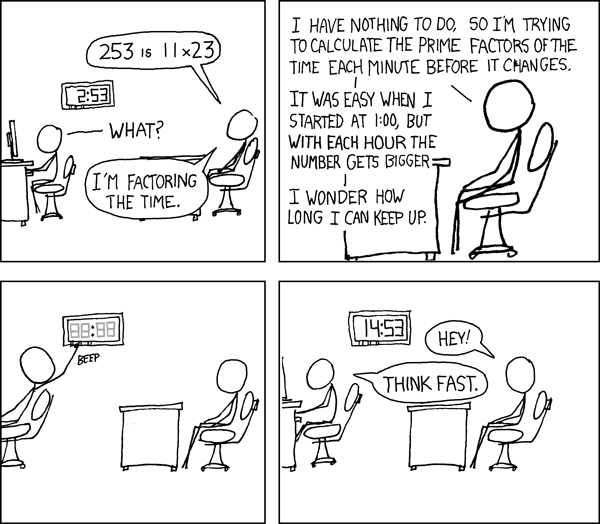 

#### Task 1 

Implement instrisic evaluation using wordsim353 benchamark. For computing correlations (step 3) use [```spearmanr```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) and [```pearsonr```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) from ```scipy.stats```

In [54]:
#w1[0].reshape()
w1.shape

(300,)

In [56]:
#TODO: implement WS353 evaluation benchmark in the three steps below.

# Step 0: (re)load the data

ws353_df = pd.read_csv(datapath('wordsim353.tsv'), sep="\t", skiprows=1).rename(columns={"# Word 1": "Word 1"})

# Step 1: Get embeddings (use ws353_df defined above)
w1 = word_emb[ws353_df["Word 1"]] # shape: |D| x word_emb_size
w2 = word_emb[ws353_df["Word 2"]] # shape: |D| x word_emb_size

# Step 2: Compute Cosine similarities
cos_mat = cosine_similarity(w1, w2) # shape: |D| x |D|
cos_pairs = np.diag(cos_mat) # shape |D|

# Step 3: Compute correlations
print(pearsonr(cos_pairs, ws353_df["Human (mean)"]))
print(spearmanr(cos_pairs, ws353_df["Human (mean)"]))

PearsonRResult(statistic=0.6525349523095118, pvalue=3.373431391524034e-44)
SignificanceResult(statistic=0.7000166486272194, pvalue=2.86866666051422e-53)


## Part 2 : Pretraining your own embeddings

- Up to know we have used embeddings that someone else trained for us
- What if you want to pretrain your own embeddings for you domain or task of interest?
- The first thing we need is data!

In [57]:
corpus = open(datapath('lee_background.cor'))
sample = corpus.readline()
print(sample, utils.simple_preprocess(sample))

Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year's Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are available at this

In [60]:
class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = datapath('lee_background.cor')
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

### Let's pretrain our own embeddings

- We will use the [```Word2Vec```](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) class from ```gensim.models```
- Let's look at the most important parameters

In [61]:
model = Word2Vec(sentences=MyCorpus(), 
                               min_count=3, # ignore all words with freq < min_count
                               vector_size=200, # dimensionality of the vectors
                               sg=1, # 1 for skip-gram, 0 for CBOW
                               epochs=10, # num_epochs
                               alpha=0.025, # initial learning rate
                               batch_words=10000, # batch size
                               window=5, # window size for context words
                               negative=10, # number of negatives for negative sampling
                               ns_exponent=0.75 # exponent of the sampling distribution
                              )
print(model)
word_emb_lee = model.wv # wv attribute contains word embeddings

Word2Vec<vocab=2747, vector_size=200, alpha=0.025>


### Saving and loading your embeddings

- Saving or loading the full model (i.e. embeddings + hyperparameters)
    - This allows to resume training

In [64]:
save_path = "word2vee_lee.model"
model.save(save_path)
model_reloaded = Word2Vec.load(save_path)

- Saving or loading **only** word embeddings
    - This does **NOT** allow to resume training

In [65]:
save_path = "word2vee_lee.emb"
model.wv.save(save_path)
emb_reloaded = KeyedVectors.load(save_path)

## Part 3 : Extrinsic evaluation of word embeddings

- Up to know we have evaluated words embeddings intrisically
- Let's try to see how they fare in a real world task
- We will use them to solve a spam classification task

- Please now run all cells below!
    - You will need them for **Task 2**
- Remember to put ```SMSSpamCollection.tsv``` in the same folder as this notebook
    - Or upload it if you're using Colab

In [66]:
spam_df = pd.read_csv("SMSSpamCollection.tsv", sep="\t", header=None, names=["label", "text"])

In [67]:
# Let's do one-hot encoding of the labels
label_encoder = LabelEncoder()
spam_df["label"] = label_encoder.fit_transform(spam_df["label"])
spam_df

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


### Building a classification model 
- We want to use a standard ML approach
- We will first preprocess the text:
    - lowercasing
    - tokenization
    - stopword removal
- After this, we will create a sentence embedding of each SMS as the average of word embeddings in that sentence

In [68]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [69]:
# lowercase, tokenize and stopword removal
stop_words = set(stopwords.words('english'))
spam_df["preprocessed_text"] = spam_df["text"].apply(lambda sentence: [word for word in utils.simple_preprocess(sentence) if word not in stop_words])
spam_df

,label,text,preprocessed_text
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, g..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,"[dun, say, early, hor, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goes, usf, lives, around, though]"
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,"[nd, time, tried, contact, pound, prize, claim..."
5568,0,Will ü b going to esplanade fr home?,"[going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...","[pity, mood, suggestions]"
5570,0,The guy did some bitching but I acted like i'd...,"[guy, bitching, acted, like, interested, buyin..."


In [70]:
# Create sentence embeddings
spam_df["sent_emb"] = spam_df["preprocessed_text"].apply(lambda tok_sentence: np.mean([word_emb[word] for word in tok_sentence if word in word_emb.key_to_index], axis=0))

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.



In [71]:
spam_df = spam_df.dropna()

In [72]:
all_features = spam_df.drop(columns="label")
features_train, features_test, y_train, y_test = train_test_split(all_features , spam_df["label"], test_size=0.2, random_state=2023, stratify=spam_df["label"])

In [73]:
print(features_train.shape, features_test.shape)

(4444, 3) (1111, 3)


### Logistic regression classifier on top of these sentence embeddings

In [76]:
logreg_model = LogisticRegressionCV(Cs=10, cv=5, penalty='l2', max_iter=1000)
sent_emb_train = np.stack(features_train["sent_emb"]) # shape: train_size x 300
logreg_model.fit(sent_emb_train, y_train) # 5-fold GridSearchCV followed by training of full model  

LogisticRegressionCV(cv=5, max_iter=1000)

In [77]:
sent_emb_test = np.stack(features_test["sent_emb"])
print(f"Accuracy of the model {logreg_model.score(sent_emb_test, y_test)}")

Accuracy of the model 0.9567956795679567


In [78]:
print(classification_report(y_test, logreg_model.predict(sent_emb_test), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         ham       0.97      0.98      0.98       962
        spam       0.87      0.79      0.83       149

    accuracy                           0.96      1111
   macro avg       0.92      0.89      0.90      1111
weighted avg       0.96      0.96      0.96      1111



### Sneak-peek: using gensim embeddings in PyTorch

In [91]:
embs = nn.Embedding(len(word_emb.key_to_index), 300).from_pretrained(torch.from_numpy(word_emb.vectors))
idx = torch.LongTensor([word_emb.key_to_index[word] for word in ["soccer", "tennis", "football"]])
embs(idx)

tensor([[-7.6660e-02,  1.1035e-01,  3.5352e-01, -7.9102e-02, -5.0049e-02,
         -2.9688e-01,  1.0938e-01, -3.5938e-01, -8.7402e-02, -7.0312e-02,
          2.0801e-01, -2.4512e-01, -5.5664e-02,  2.4219e-01,  2.3560e-02,
         -8.6670e-03,  2.6855e-02,  4.0234e-01,  1.7480e-01, -1.6602e-02,
         -2.0410e-01,  5.0000e-01, -8.9844e-02, -1.4355e-01,  5.5420e-02,
          9.0820e-02,  1.1426e-01,  1.5430e-01,  1.3477e-01,  2.2656e-01,
          4.4189e-02,  3.7109e-02, -1.1621e-01, -1.1328e-01, -1.6479e-02,
         -1.2695e-01,  2.9883e-01, -1.2598e-01,  1.0303e-01,  3.1641e-01,
          1.2665e-03, -8.8379e-02,  1.2695e-01,  1.5820e-01, -7.1777e-02,
         -2.1094e-01,  3.1641e-01, -2.0801e-01,  9.6893e-04,  3.2422e-01,
          7.1289e-02,  7.1289e-02, -9.2285e-02, -2.2705e-02,  9.5703e-02,
         -2.9883e-01, -6.5918e-02, -7.0801e-02, -7.4219e-02, -2.3535e-01,
         -2.8320e-01, -2.0215e-01, -1.6211e-01,  2.2070e-01, -2.3682e-02,
         -1.0645e-01,  1.9653e-02, -5.

### It's your turn! Go ahead with *Task 2.*

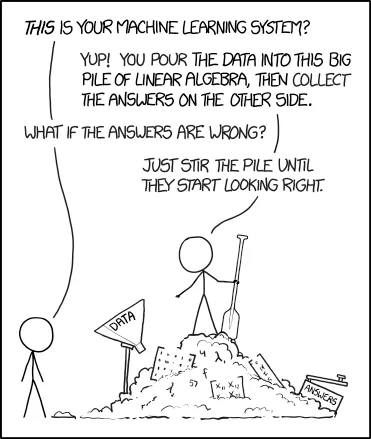

#### Task 2.1

- Plot the 3D PCA representation of the sentence embeddings, using a different color for each label (ham and spam)
    - Are the two classes neatly separated?

#### Task 2.2

1. Implement a new classifier to solve this task.
    - You can use:
        - a ```scikit-learn``` estimator, for example: [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
        - **only** if you are confident with your pytorch skills, you can implement either:
            - a feed-forward network that processes the sentence embeddings
            - a RNN of your choice (LSTM, GRU, BiLSTM) that processes one word per time step 
    - **Requirements**:
        - use the same train_test split done above (```sent_emb_train``` / ```sent_emb_test```)
2. Evaluate your model on the test set using classification_report

In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

# Find best hyperparameter combination according to F1 score and then refit the best estimator on the entire training set
grid_search = GridSearchCV(SVC(), tuned_parameters, cv=5, scoring="f1", refit="f1")
grid_search.fit(sent_emb_train, y_train) # GridSearch with 5-fold cross validation followed by training of the best model on entire training set

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             refit='f1', scoring='f1')

In [96]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(sent_emb_test)
print(f"accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

accuracy: 0.963996399639964
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       962
        spam       0.90      0.82      0.86       149

    accuracy                           0.96      1111
   macro avg       0.94      0.90      0.92      1111
weighted avg       0.96      0.96      0.96      1111

